# Pipeline Demo

### Setting up environment
Use ```cluster/new_vm_setup.sh``` script to set up environment on a new virtual machine and install required libraries
<br>
Command: ```sh cluster/new_vm_setup.sh```
<br>
<br>
Clone ```glacier_mapping``` repo from github to your working directory on your VM
<br>
Command: ```git clone git@github.com:krisrs1128/glacier_mapping.git```

### Mounting Azure Blobs containing required data

Use shared ```mount.sh``` shell script to mount blob and required files into you VM. 
<br>
<font color='red'> Note: </font>Keep this file locally and do not share. It contains passwords to access VMs.


## Data Pre-processing for training models
Steps to go from raw tiff to data ready for madel training

### Groundtruth Generation
Generate pixel-wise Masks/GT for raw satellite image using vector data labels. 

Note: This part uses ```masking_paths.yaml``` from ```conf``` folder. Please, ensure paths are pointing to the correct directories

In [2]:
# Setting up environmental variables
%env ROOT_DIR=/home/aortiz/research_projects/glacier_mapping
%env DATA_DIR=/mnt/blobfuse/glaciers/pipeline_demo/demo_data/data/

env: ROOT_DIR=/home/aortiz/research_projects/glacier_mapping
env: DATA_DIR=/mnt/blobfuse/glaciers/pipeline_demo/demo_data/data/


In [8]:
# Loading libraries
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


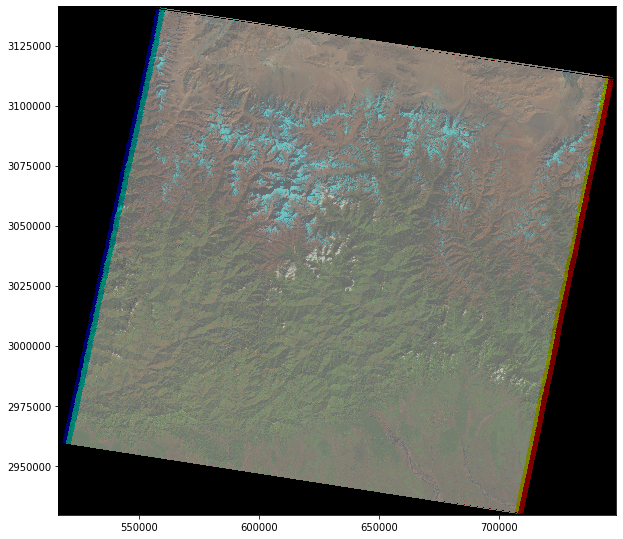

In [28]:
# Visualizing raw input file
import rasterio.plot as rp
data = rasterio.open('/mnt/blobfuse/glaciers/pipeline_demo/demo_data/data/2005/nepal/LE07_139041_20051208.tif')
RGB = data.read((5,4,2))
max_val = np.nanmax(RGB.reshape(RGB.shape[0]*RGB.shape[1]*RGB.shape[2]))
min_val = np.nanmin(RGB.reshape(RGB.shape[0]*RGB.shape[1]*RGB.shape[2]))
norm_RGB = (RGB - min_val) / (max_val - min_val)
plt.rcParams['figure.figsize'] = [10, 10]
rp.show(norm_RGB, transform=data.transform)

In [45]:
!python -m src.data.mask -m conf/masking_paths.yaml


working on image 1 / 1


(7058, 7747, 2)


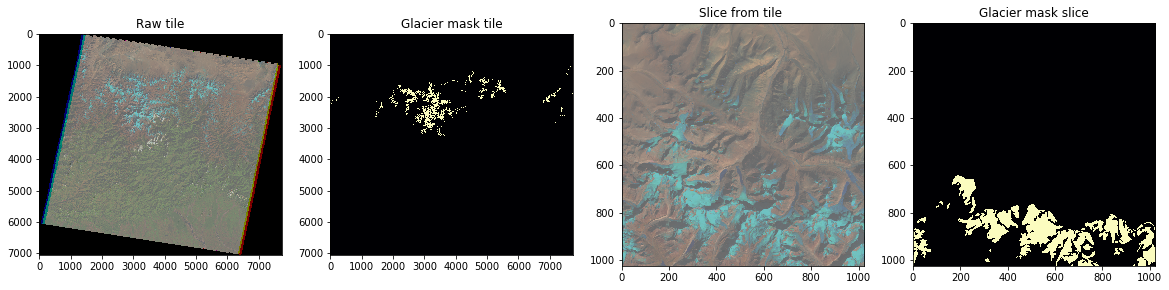

In [26]:
def plot_mask():    
    fig = plt.figure(figsize=(20,20))

    plt.subplot(1,4,1)
    plt.imshow(np.moveaxis(norm_RGB, 0, -1))
    plt.title('Raw tile')

    plt.subplot(1,4,2)
    plt.imshow(np.argmax(mask, axis=2), cmap='magma')
    plt.title('Glacier mask tile')
    #plt.show()
    
    plt.subplot(1,4,3)
    plt.imshow(np.moveaxis(norm_RGB, 0, -1)[1000:2024,2000:3024,:])
    plt.title('Slice from tile ')
    #plt.show()

    plt.subplot(1,4,4)
    plt.imshow(np.argmax(mask, axis=2)[1000:2024,2000:3024], cmap='magma')
    plt.title('Glacier mask slice')
    plt.show()

mask = np.load('/mnt/blobfuse/glaciers/pipeline_demo/demo_data/data/processed/masks/mask_00.npy')
print(mask.shape)
plot_mask()

### Slice image tiles and corresponding mask
It is advised to slicwe tiles in patches to create training samples for training models. 
<br>
Command: ```python -m src.slice -m dir2data/processed/masks/mask_metadata.csv -o dir2storeslices/```


In [4]:
!python -m src.data.slice -m /mnt/blobfuse/glaciers/pipeline_demo/demo_data/data/processed/masks/mask_metadata.csv -o /mnt/blobfuse/glaciers/pipeline_demo/demo_data/data/processed/slices/

## Slicing tiff 1/1 ...
100%|█████████████████████████████████████| 195/195 [00:00<00:00, 647064.30it/s]
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/data/anaconda/envs/gmtool/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py", line 418, in _process_worker
    r = call_item()
  File "/data/anaconda/envs/gmtool/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py", line 272, in __call__
    return self.fn(*self.args, **self.kwargs)
  File "/data/anaconda/envs/gmtool/lib/python3.6/site-packages/joblib/_parallel_backends.py", line 608, in __call__
    return self.func(*args, **kwargs)
  File "/data/anaconda/envs/gmtool/lib/python3.6/site-packages/joblib/parallel.py", line 256, in __call__
    for func, args, kwargs in self.items]
  File "/data/anaconda/envs/gmtool/lib/python3.6/site-packages/joblib/parallel.py", line 256, in <listcomp>
    for func, args, kwargs in self.items]
  File "/data/h

In [6]:
!python -m src.data.process_slices -c conf/postprocess.yaml -d /mnt/blobfuse/glaciers/pipeline_demo/demo_data/data/processed/slices/ -m /mnt/blobfuse/glaciers/pipeline_demo/demo_data/data/processed/slices/slices_0-100.geojson -o /mnt/blobfuse/glaciers/pipeline_demo/demo_data/data/processed

filtering
reshuffling
shuffling image 0 - img
shuffling image 1 - img
shuffling image 2 - img
shuffling image 0 - mask
shuffling image 2 - mask
shuffling image 1 - mask
shuffling image 3 - img
shuffling image 4 - img
shuffling image 5 - img
shuffling image 5 - mask
shuffling image 6 - img
shuffling image 4 - mask
shuffling image 3 - mask
shuffling image 7 - img
shuffling image 6 - mask
shuffling image 7 - mask
shuffling image 0 - img
shuffling image 0 - mask
shuffling image 0 - img
shuffling image 1 - img
shuffling image 0 - mask
shuffling image 1 - mask
getting stats
postprocessing train...
postprocessing dev...
postprocessing test...


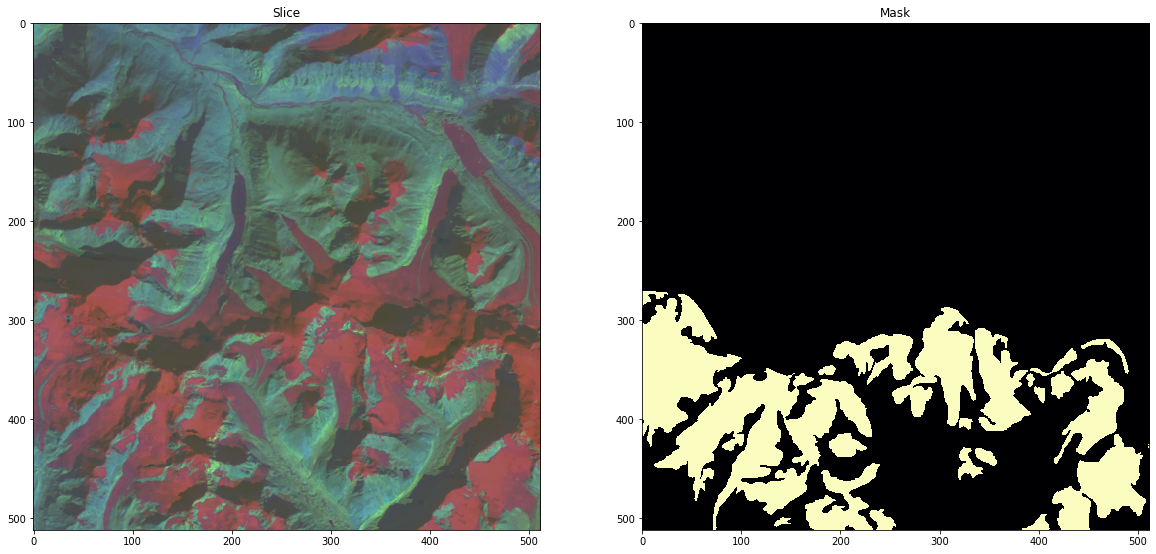

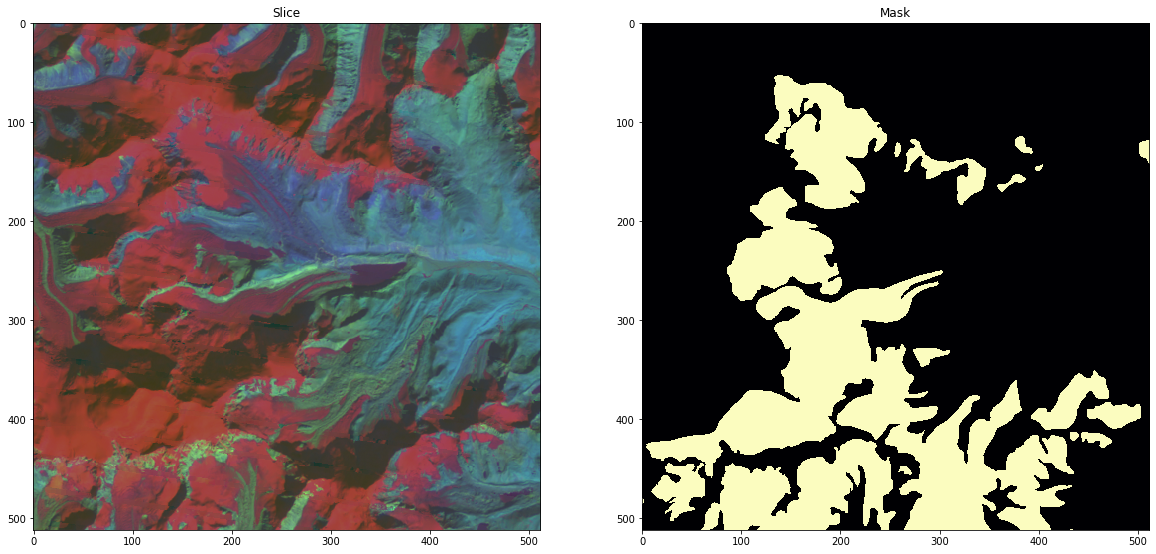

In [30]:
def plot_training_slices(img, mask):    
    fig = plt.figure(figsize=(20,20))

    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title('Slice')

    plt.subplot(1,2,2)
    plt.imshow(np.squeeze(mask), cmap='magma')
    plt.title('Mask')
    plt.show()
    
slice_sample = np.load('/mnt/blobfuse/glaciers/pipeline_demo/demo_data/data/processed/train/slice_0_img_050.npy') 
min_val = np.nanmin(slice_sample.reshape(slice_sample.shape[0]*slice_sample.shape[1]*slice_sample.shape[2]))
max_val = np.nanmax(slice_sample.reshape(slice_sample.shape[0]*slice_sample.shape[1]*slice_sample.shape[2]))
norm_slice = (slice_sample - min_val) / (max_val - min_val)
mask_sample = np.load('/mnt/blobfuse/glaciers/pipeline_demo/demo_data/data/processed/train/slice_0_mask_050.npy')
plot_training_slices(norm_slice, mask_sample)

slice_sample = np.load('/mnt/blobfuse/glaciers/pipeline_demo/demo_data/data/processed/train/slice_0_img_051.npy') 
min_val = np.nanmin(slice_sample.reshape(slice_sample.shape[0]*slice_sample.shape[1]*slice_sample.shape[2]))
max_val = np.nanmax(slice_sample.reshape(slice_sample.shape[0]*slice_sample.shape[1]*slice_sample.shape[2]))
norm_slice = (slice_sample - min_val) / (max_val - min_val)
mask_sample = np.load('/mnt/blobfuse/glaciers/pipeline_demo/demo_data/data/processed/train/slice_0_mask_051.npy')
plot_training_slices(norm_slice, mask_sample)


### Model training

You will be able to train models using previously crated slices running the ```src.train``` script.

Models will be saved under ```$root_dir/runs/$name_provided_with_src_train/mondels/```

In [31]:
!python -m src.train -n train_demo -c conf/train.yaml

Epoch 1/500, Training batch 1 of 1, Loss= 2.58213
T_Loss: 5.16425 , IoU: 0.234 , pixel_acc: 0.234 , precision: 0.234 , recall: 1.000 
V_Loss: 40.92693 , IoU: 1.873 , pixel_acc: 1.873 , precision: 1.873 , recall: 8.000 

Epoch 2/500, Training batch 1 of 1, Loss= 2.55794
T_Loss: 5.11587 , IoU: 0.234 , pixel_acc: 0.234 , precision: 0.234 , recall: 1.000 
V_Loss: 40.54184 , IoU: 1.873 , pixel_acc: 1.873 , precision: 1.873 , recall: 8.000 

Epoch 3/500, Training batch 1 of 1, Loss= 2.53388
T_Loss: 5.06775 , IoU: 0.234 , pixel_acc: 0.234 , precision: 0.234 , recall: 1.000 
V_Loss: 40.15759 , IoU: 1.873 , pixel_acc: 1.873 , precision: 1.873 , recall: 8.000 

Epoch 4/500, Training batch 1 of 1, Loss= 2.51001
T_Loss: 5.02003 , IoU: 0.234 , pixel_acc: 0.234 , precision: 0.234 , recall: 1.000 
V_Loss: 39.78129 , IoU: 1.873 , pixel_acc: 1.873 , precision: 1.873 , recall: 8.000 

Epoch 5/500, Training batch 1 of 1, Loss= 2.48630
T_Loss: 4.97260 , IoU: 0.234 , pixel_acc: 0.234 , precision: 0.234 , r

Epoch 75/500, Training batch 1 of 1, Loss= 1.14413
T_Loss: 2.28825 , IoU: 0.234 , pixel_acc: 0.236 , precision: 0.234 , recall: 1.000 
V_Loss: 18.06973 , IoU: 1.875 , pixel_acc: 1.890 , precision: 1.875 , recall: 8.000 

Epoch 76/500, Training batch 1 of 1, Loss= 1.12958
T_Loss: 2.25916 , IoU: 0.234 , pixel_acc: 0.235 , precision: 0.234 , recall: 1.000 
V_Loss: 17.81298 , IoU: 1.874 , pixel_acc: 1.879 , precision: 1.874 , recall: 8.000 

Epoch 77/500, Training batch 1 of 1, Loss= 1.11491
T_Loss: 2.22981 , IoU: 0.235 , pixel_acc: 0.238 , precision: 0.235 , recall: 1.000 
V_Loss: 17.60271 , IoU: 1.878 , pixel_acc: 1.906 , precision: 1.878 , recall: 8.000 

Epoch 78/500, Training batch 1 of 1, Loss= 1.10111
T_Loss: 2.20223 , IoU: 0.234 , pixel_acc: 0.236 , precision: 0.234 , recall: 1.000 
V_Loss: 17.37220 , IoU: 1.874 , pixel_acc: 1.887 , precision: 1.874 , recall: 8.000 

Epoch 79/500, Training batch 1 of 1, Loss= 1.08662
T_Loss: 2.17325 , IoU: 0.234 , pixel_acc: 0.234 , precision: 0.23

Epoch 149/500, Training batch 1 of 1, Loss= 0.40347
T_Loss: 0.80694 , IoU: 0.473 , pixel_acc: 0.808 , precision: 0.621 , recall: 0.729 
V_Loss: 6.47111 , IoU: 3.784 , pixel_acc: 6.464 , precision: 4.971 , recall: 5.830 

Epoch 150/500, Training batch 1 of 1, Loss= 0.39871
T_Loss: 0.79743 , IoU: 0.478 , pixel_acc: 0.803 , precision: 0.609 , recall: 0.757 
V_Loss: 6.32813 , IoU: 3.821 , pixel_acc: 6.422 , precision: 4.874 , recall: 6.060 

Epoch 151/500, Training batch 1 of 1, Loss= 0.39536
T_Loss: 0.79072 , IoU: 0.419 , pixel_acc: 0.726 , precision: 0.507 , recall: 0.817 
V_Loss: 6.30100 , IoU: 3.353 , pixel_acc: 5.807 , precision: 4.055 , recall: 6.539 

Epoch 152/500, Training batch 1 of 1, Loss= 0.38857
T_Loss: 0.77713 , IoU: 0.440 , pixel_acc: 0.761 , precision: 0.565 , recall: 0.775 
V_Loss: 6.22389 , IoU: 3.523 , pixel_acc: 6.089 , precision: 4.522 , recall: 6.199 

Epoch 153/500, Training batch 1 of 1, Loss= 0.38185
T_Loss: 0.76370 , IoU: 0.403 , pixel_acc: 0.814 , precision: 0.6

Epoch 223/500, Training batch 1 of 1, Loss= 0.15916
T_Loss: 0.31833 , IoU: 0.528 , pixel_acc: 0.838 , precision: 0.640 , recall: 0.788 
V_Loss: 2.84262 , IoU: 4.223 , pixel_acc: 6.703 , precision: 5.123 , recall: 6.307 

Epoch 224/500, Training batch 1 of 1, Loss= 0.15869
T_Loss: 0.31738 , IoU: 0.522 , pixel_acc: 0.830 , precision: 0.643 , recall: 0.788 
V_Loss: 2.83163 , IoU: 4.176 , pixel_acc: 6.641 , precision: 5.141 , recall: 6.302 

Epoch 225/500, Training batch 1 of 1, Loss= 0.15795
T_Loss: 0.31590 , IoU: 0.448 , pixel_acc: 0.832 , precision: 0.706 , recall: 0.637 
V_Loss: 2.82870 , IoU: 3.582 , pixel_acc: 6.655 , precision: 5.646 , recall: 5.096 

Epoch 226/500, Training batch 1 of 1, Loss= 0.15425
T_Loss: 0.30851 , IoU: 0.527 , pixel_acc: 0.835 , precision: 0.662 , recall: 0.770 
V_Loss: 2.84431 , IoU: 4.218 , pixel_acc: 6.682 , precision: 5.299 , recall: 6.160 

Epoch 227/500, Training batch 1 of 1, Loss= 0.15450
T_Loss: 0.30901 , IoU: 0.500 , pixel_acc: 0.814 , precision: 0.6

Epoch 297/500, Training batch 1 of 1, Loss= 0.07920
T_Loss: 0.15839 , IoU: 0.516 , pixel_acc: 0.835 , precision: 0.659 , recall: 0.769 
V_Loss: 2.18671 , IoU: 4.129 , pixel_acc: 6.684 , precision: 5.268 , recall: 6.154 

Epoch 298/500, Training batch 1 of 1, Loss= 0.07825
T_Loss: 0.15650 , IoU: 0.543 , pixel_acc: 0.840 , precision: 0.621 , recall: 0.829 
V_Loss: 1.57651 , IoU: 4.346 , pixel_acc: 6.718 , precision: 4.972 , recall: 6.632 

Epoch 299/500, Training batch 1 of 1, Loss= 0.07898
T_Loss: 0.15797 , IoU: 0.519 , pixel_acc: 0.832 , precision: 0.647 , recall: 0.783 
V_Loss: 1.47386 , IoU: 4.152 , pixel_acc: 6.655 , precision: 5.174 , recall: 6.262 

Epoch 300/500, Training batch 1 of 1, Loss= 0.07858
T_Loss: 0.15716 , IoU: 0.513 , pixel_acc: 0.820 , precision: 0.651 , recall: 0.777 
V_Loss: 1.91816 , IoU: 4.105 , pixel_acc: 6.563 , precision: 5.209 , recall: 6.217 

Epoch 301/500, Training batch 1 of 1, Loss= 0.07858
T_Loss: 0.15716 , IoU: 0.526 , pixel_acc: 0.828 , precision: 0.6

Epoch 371/500, Training batch 1 of 1, Loss= 0.05156
T_Loss: 0.10313 , IoU: 0.540 , pixel_acc: 0.835 , precision: 0.625 , recall: 0.838 
V_Loss: 1.53547 , IoU: 4.324 , pixel_acc: 6.680 , precision: 5.004 , recall: 6.705 

Epoch 372/500, Training batch 1 of 1, Loss= 0.05331
T_Loss: 0.10662 , IoU: 0.508 , pixel_acc: 0.817 , precision: 0.624 , recall: 0.799 
V_Loss: 1.31559 , IoU: 4.065 , pixel_acc: 6.535 , precision: 4.993 , recall: 6.392 

Epoch 373/500, Training batch 1 of 1, Loss= 0.05125
T_Loss: 0.10251 , IoU: 0.532 , pixel_acc: 0.834 , precision: 0.625 , recall: 0.826 
V_Loss: 1.63405 , IoU: 4.253 , pixel_acc: 6.673 , precision: 4.999 , recall: 6.607 

Epoch 374/500, Training batch 1 of 1, Loss= 0.05290
T_Loss: 0.10579 , IoU: 0.530 , pixel_acc: 0.834 , precision: 0.653 , recall: 0.789 
V_Loss: 1.95204 , IoU: 4.237 , pixel_acc: 6.670 , precision: 5.223 , recall: 6.309 

Epoch 375/500, Training batch 1 of 1, Loss= 0.05128
T_Loss: 0.10257 , IoU: 0.551 , pixel_acc: 0.844 , precision: 0.6

Epoch 445/500, Training batch 1 of 1, Loss= 0.04016
T_Loss: 0.08032 , IoU: 0.536 , pixel_acc: 0.830 , precision: 0.629 , recall: 0.827 
V_Loss: 1.34206 , IoU: 4.290 , pixel_acc: 6.644 , precision: 5.030 , recall: 6.614 

Epoch 446/500, Training batch 1 of 1, Loss= 0.04011
T_Loss: 0.08021 , IoU: 0.536 , pixel_acc: 0.837 , precision: 0.631 , recall: 0.812 
V_Loss: 1.30835 , IoU: 4.285 , pixel_acc: 6.692 , precision: 5.045 , recall: 6.497 

Epoch 447/500, Training batch 1 of 1, Loss= 0.04012
T_Loss: 0.08025 , IoU: 0.538 , pixel_acc: 0.834 , precision: 0.638 , recall: 0.816 
V_Loss: 1.73689 , IoU: 4.308 , pixel_acc: 6.673 , precision: 5.107 , recall: 6.526 

Epoch 448/500, Training batch 1 of 1, Loss= 0.04046
T_Loss: 0.08093 , IoU: 0.541 , pixel_acc: 0.826 , precision: 0.620 , recall: 0.849 
V_Loss: 1.11423 , IoU: 4.324 , pixel_acc: 6.610 , precision: 4.961 , recall: 6.796 

Epoch 449/500, Training batch 1 of 1, Loss= 0.04004
T_Loss: 0.08007 , IoU: 0.487 , pixel_acc: 0.838 , precision: 0.6

### Offline inference 
```-m``` --> path to model
<br>
```-i``` --> raw tiff to do inference on

In [ ]:
!python -m src.infer -m /mnt/blobfuse/glaciers/pipeline_demo/demo_data/runs/train_demo/models/model_5.pt -i /mnt/blobfuse/glaciers/pipeline_demo/demo_data/data/2005/nepal/LE07_141040_20051104.tif

## Glacier Mapping Web Tool
